# Table of Contents

* [Introduction](#section-one)
    
* [IndexFlatL2](#section-two)
    
* [IndexIVFFlat](#section-three)
    
* [IndexIVFPQ (Quantization)](#section-four)

<a id="section-one"></a>
# Introduction

**Faiss**, which stands for **"Facebook AI Similarity Search,"** is a powerful and efficient library for similarity search and similarity indexing. 

Developed by Facebook AI Research, Faiss is primarily used for searching and indexing high-dimensional data, making it a valuable tool in various applications, including natural language processing, computer vision, and recommendation systems. Key features and characteristics of Faiss include:

1. **Efficient Vector Search**: Faiss is optimized for fast similarity search in large datasets of high-dimensional vectors. It provides both exact and approximate search algorithms, making it suitable for a wide range of use cases.

2. **GPU Support**: Faiss includes GPU support, allowing users to take advantage of the computational power of modern graphics processing units to accelerate similarity search operations.

3. **Diverse Indexing Structures**: Faiss provides a variety of indexing structures, including flat indexes, IVF (Inverted File) indexes, HNSW (Hierarchical Navigable Small World) indexes, and more, each tailored to specific data and performance requirements. *We will discuss some of them in this notebook*. 

4. **Integration with Deep Learning**: Faiss is often used in conjunction with deep learning models, making it a valuable tool for encoding text, images, and other data into high-dimensional vectors. These vectors can then be efficiently searched and indexed.

5. **Wide Range of Applications**: Faiss is used in various applications, including content-based recommendation systems, similarity-based search engines, image retrieval, and document clustering, to name a few.

6. **Scalability**: Faiss is designed to handle large datasets, making it suitable for both small-scale projects and large-scale production systems.



**Let's implement some of the major Indexing Structures!**

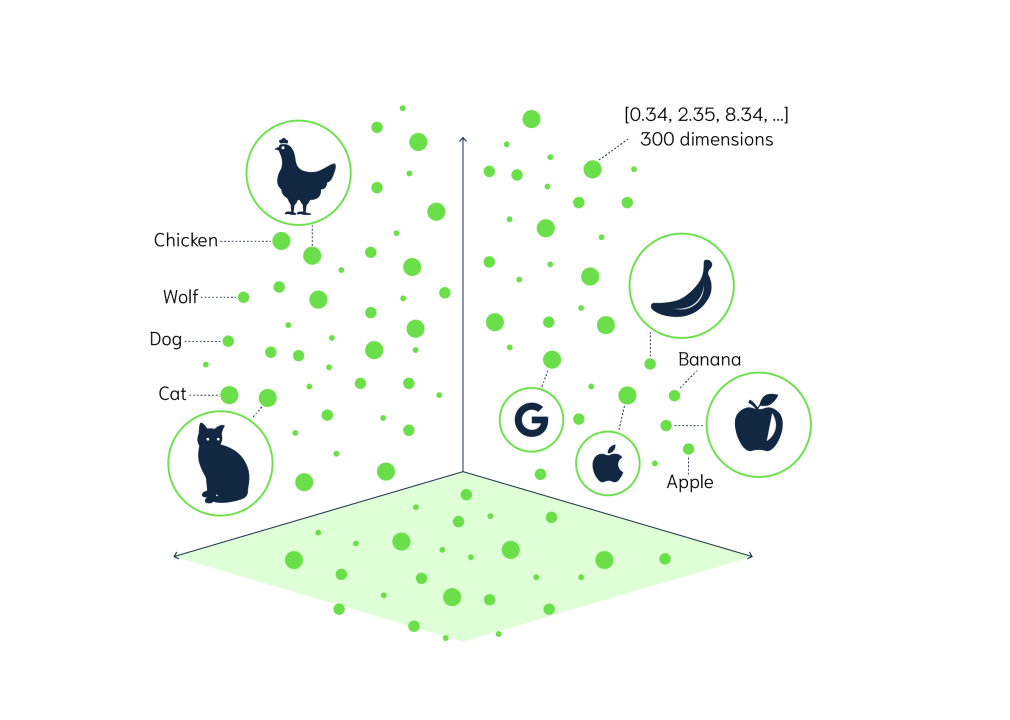

In [1]:
%%bash

pip install faiss-gpu sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=705c9f6bc94d2ca098d8a718e7403fa280e26c878a3aa70bc658e013a1373eed
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time

import faiss
from sentence_transformers import SentenceTransformer
import torch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df_news = pd.read_csv("../input/news-summary/news_summary_more.csv")

In [4]:
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentenceTransformer("all-MiniLM-L6-v2", device=torch_device)

In [5]:
# modelPath = "local/path/to/model"

# model.save(path="./sentence_transformer_trained_model")
# model = SentenceTransformer("./sentence_transformer_trained_model")

In [6]:
news_text = df_news.text.values.tolist()
len(news_text)

98401

<a id="section-two"></a>

# 1. IndexFlatL2

- This is the simplest index structure where all data points are stored without any transformation (compression). This type of index doesn’t compress or cluster your vectors. Flat indexes are ‘flat’ because they do not modify the vectors that we feed into them. 

- Because there is no approximation or clustering of vectors — these indexes produce the most accurate results. We have perfect search quality, but this comes at the cost of significant search times.

- With flat indexes, we introduce our query vector xq and compare it against every other full-size vector in our index — calculating the distance/inner-product to each. This is an EXHAUSTIVE SERACH.

- After calculating all of these distances, we will return the nearest k of those as our nearest matches. A k-nearest neighbors (kNN) search.

- And for flat indexes, that is all we need to do — there is no training (as we have no parameters to optimize when storing vectors without transformations or clustering).

- **When To Use** - 

    - Search quality is a very high priority.

    - Search time does not matter OR when using a small index (<10K)

In [7]:
embedding = model.encode(news_text)
# dimension
dimension = embedding.shape[1]

Batches:   0%|          | 0/3076 [00:00<?, ?it/s]

In [8]:
def create_index(data, text_column, model):
    embedding = model.encode(data[text_column].to_list())
    
    # dimension
    dimension = embedding.shape[1]
    
    # create the vector/embeddings and their IDs                                                                                                                                                                                                                                                embedding vectors and ids:
    db_vectors = embedding.copy().astype(np.float32)
    db_ids = data.index.values.astype(np.int64)

    faiss.normalize_L2(db_vectors)
    index = faiss.IndexFlatIP(dimension)
    index = faiss.IndexIDMap(index)
    index.add_with_ids(db_vectors, db_ids)
    
    return index

def search_your_query(index, model, query, k):
    
    t=time.time()
    query_vector = model.encode([query]).astype(np.float32)
    faiss.normalize_L2(query_vector)
    
    similarities, similarities_ids = index.search(query_vector, k)
    print('totaltime: {}\n'.format(time.time()-t))
    
    similarities = np.clip(similarities, 0, 1)
    
    output = []
    for i in range(len(similarities_ids[0])):
        item = {
            'id': similarities_ids[0][i],
            'text': df_news.loc[similarities_ids[0][i], 'text'],
            'similarity_score': similarities[0][i]
        }
        output.append(item)
    
    return output

In [9]:
index_flatIP = create_index(data=df_news, 
                          text_column='text', 
                          model=model)

Batches:   0%|          | 0/3076 [00:00<?, ?it/s]

In [10]:
index_flatIP.ntotal

98401

In [11]:
# faiss.write_index(index_flatIP, 'news_dataset_index')

# # Deserializing the index
# index_read = faiss.read_index('news_dataset_index')

In [12]:
search_your_query(index=index_flatIP, 
                  model=model, 
                  query="Artificial Intelligence", 
                  k=5)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

totaltime: 0.07182645797729492



[{'id': 17667,
  'text': 'A team of researchers from MIT has developed an AI system that imitates human reasoning abilities to solve problems with 99.1% accuracy. The system performs human-like reasoning steps to answer questions about the contents of images. It also visually displays its thought process as it solves problems, allowing human analysts to interpret its decision-making process. ',
  'similarity_score': 0.60047615},
 {'id': 27678,
  'text': "Researchers at the California Institute of Technology have developed an artificial intelligence (AI) tool which can predict a human's IQ by looking at their brain scans. To train the AI, they downloaded the brain scans and intelligence scores from almost 900 individuals. The researchers found the algorithm was able to predict intelligence at statistically significant levels across the subjects.",
  'similarity_score': 0.54453385},
 {'id': 8692,
  'text': 'Artificial intelligence-based consumer electronics startup GOQii\'s Founder and C

In [13]:
search_your_query(index=index_flatIP, 
                  model=model, 
                  query="Data Science", 
                  k=5)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

totaltime: 0.07597637176513672



[{'id': 8648,
  'text': "UpGrad and IIIT-Bangalore's PG Program in Data Science program have launched a track with placement assurance that guarantees a job in the field of Data within 6 months of graduation to 100 shortlisted candidates. Learners will be provided with 1:1 mentorship by experienced Data professionals from companies such as Walmart Labs, Flipkart and Fractal Analytics.",
  'similarity_score': 0.516843},
 {'id': 7343,
  'text': 'UpGrad has announced a scholarship worth â\x82¹5 crore for its PG program in Data Science, in collaboration with IIIT-Bangalore. Data Science as a field has seen an increase in jobs by 650% since 2012. Professionals can transition to the field of Data Science through this program with a scholarship of up to  â\x82¹1 lakh.',
  'similarity_score': 0.50958997},
 {'id': 9958,
  'text': "According to Forbes, Data Science jobs have grown 650% since 2012. UpGrad and IIIT-Bangalore's PG Program in Data Science, ranked among the top 5 in India helps learn

### Scalability Issues
Using the IndexFlatL2 index alone is computationally expensive, it doesn’t scale well.

When using this index, we are performing an exhaustive search which means we compare our query vector xq to every other vector in our index, in our case that is 98k Inner Product calculations for every search.

Imagine the speed of our search for datasets containing 1M, 1B, or even more vectors — it will be insane!

# So, how can we make our search faster? 

There are two primary approaches:

1. **Reduce vector size** — through dimensionality reduction or reducing the number of bits representing our vectors values.
2. **Reduce search scope** — we can do this by clustering or organizing vectors into tree structures based on certain attributes, similarity, or distance — and restricting our search to closest clusters or filter through most similar branches.

Using either of these approaches means that we are no longer performing an exhaustive nearest-neighbors search but an approximate nearest-neighbors (ANN) search — as we no longer search the entire, full-resolution dataset. So, what we produce is a more balanced mix that prioritizes both search-speed and search-time

<a id="section-three"></a>

# 2. IndexIVFFlat

The Inverted File Index (IVF) index consists of search scope reduction through clustering. It’s a very popular index as it’s easy to use, with high search-quality and reasonable search-speed. It works on the concept of Voronoi diagrams.

To understand Voronoi diagrams, we need to imagine our highly-dimensional vectors placed into a 2D space. We then place a few additional points in our 2D space, which will become our ‘cluster’ (Voronoi cells in our case) centroids. We then extend an equal radius out from each of our centroids. At some point, the circumferences of each cell circle will collide with another — creating our cell edges.

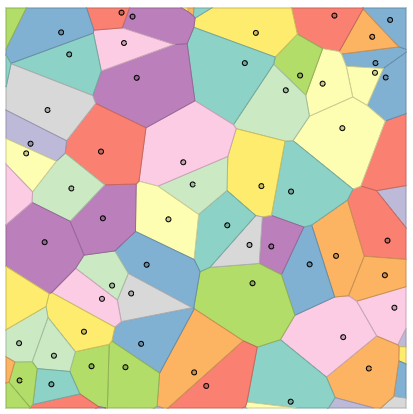

Using this method, we would take a query vector, identify the cell it belongs to, and then use our IndexFlatL2 (or another metric) to search between the query vector and all other vectors belonging to that specific cell.

*So, we are reducing the scope of our search, producing an approximate answer, rather than exact (as produced through exhaustive search).*

To implement this, we first initialize our index using IndexFlatL2 — but this time, we are using the L2 index as a quantizer step — which we feed into the partitioning IndexIVFFlat index.

In [14]:
nlist = 60  # how many Voronoi cells/partitions
quantizer = faiss.IndexFlatL2(dimension)
indexIVFFlat = faiss.IndexIVFFlat(quantizer, dimension, nlist)

In [15]:
indexIVFFlat.is_trained

False

So, what we do now is train our index on our data — which we must do before adding any data to the index.

In [16]:
indexIVFFlat.train(embedding)
indexIVFFlat.is_trained  # check if index is now trained

True

In [17]:
indexIVFFlat.add(embedding)
indexIVFFlat.ntotal  # number of embeddings indexed

98401

Now that our index is trained, we add our data just as we did before and search again using the same indexed sentence embeddings and the same query vector.

In [18]:
def search_query(index, model, query, k):
    
    t=time.time()
    query_vector = model.encode([query]).astype(np.float32)
    faiss.normalize_L2(query_vector)
    
    similarities, similarities_ids = index.search(query_vector, k)
    print('totaltime: {}\n'.format(time.time()-t))
    
    similarities = np.clip(similarities, 0, 1)
    
    output = []
    for i in range(len(similarities_ids[0])):
        item = {
            'id': similarities_ids[0][i],
            'text': df_news.loc[similarities_ids[0][i], 'text']
        }
        output.append(item)
    
    return output

In [19]:
search_query(index=indexIVFFlat,
             model=model, 
             query="Artificial Intelligence", 
             k=5)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

totaltime: 0.02856135368347168



[{'id': 17667,
  'text': 'A team of researchers from MIT has developed an AI system that imitates human reasoning abilities to solve problems with 99.1% accuracy. The system performs human-like reasoning steps to answer questions about the contents of images. It also visually displays its thought process as it solves problems, allowing human analysts to interpret its decision-making process. '},
 {'id': 27678,
  'text': "Researchers at the California Institute of Technology have developed an artificial intelligence (AI) tool which can predict a human's IQ by looking at their brain scans. To train the AI, they downloaded the brain scans and intelligence scores from almost 900 individuals. The researchers found the algorithm was able to predict intelligence at statistically significant levels across the subjects."},
 {'id': 8692,
  'text': 'Artificial intelligence-based consumer electronics startup GOQii\'s Founder and CEO Vishal Gondal has said, "There are a lot of things which AI just 

In [20]:
search_query(index=indexIVFFlat,
             model=model, 
             query="Data Science", 
             k=5)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

totaltime: 0.028281211853027344



[{'id': 4189,
  'text': 'Microsoft Taiwan and Taiwan AI Labs have jointly launched an AI-based genetic analysis platform named TaiGenomics. The platform uses artificial intelligence to analyse large amounts of medical and genetic data taken from patients and hospitals. According to Microsoft, the platform could reduce human errors and help medical experts to diagnose or predict diseases more efficiently.'},
 {'id': 28318,
  'text': "Stanford University researchers have developed an artificial intelligence (AI) programme that organised the periodic table of elements within hours. Called 'Atom2Vec', the AI learned to distinguish between atoms after analysing a list of chemical compound names from an online database. It then used the natural language processing to cluster the elements according to their chemical properties."},
 {'id': 2754,
  'text': 'Tech professionals can make their jobs future-proof with the Artificial Intelligence program offered by Great Learning in collaboration wit

The search time has clearly **decreased by 50%**, in this case, we don’t find any difference between results returned by our exhaustive search, and this approximate search. But, often this can be the case.

If approximate search with IndexIVFFlat returns suboptimal results, we can improve accuracy by increasing the search scope. We do this by increasing the nprobe attribute value — which defines how many nearby cells to search.

In [21]:
# We can increase the number of nearby cells to search too with `nprobe`
indexIVFFlat.nprobe = 8

search_query(index=indexIVFFlat,
             model=model, 
             query="Artificial Intelligence", 
             k=5)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

totaltime: 0.03284263610839844



[{'id': 17667,
  'text': 'A team of researchers from MIT has developed an AI system that imitates human reasoning abilities to solve problems with 99.1% accuracy. The system performs human-like reasoning steps to answer questions about the contents of images. It also visually displays its thought process as it solves problems, allowing human analysts to interpret its decision-making process. '},
 {'id': 27678,
  'text': "Researchers at the California Institute of Technology have developed an artificial intelligence (AI) tool which can predict a human's IQ by looking at their brain scans. To train the AI, they downloaded the brain scans and intelligence scores from almost 900 individuals. The researchers found the algorithm was able to predict intelligence at statistically significant levels across the subjects."},
 {'id': 8692,
  'text': 'Artificial intelligence-based consumer electronics startup GOQii\'s Founder and CEO Vishal Gondal has said, "There are a lot of things which AI just 

In [22]:
search_query(index=indexIVFFlat,
             model=model, 
             query="Data Science", 
             k=5)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

totaltime: 0.027137279510498047



[{'id': 8648,
  'text': "UpGrad and IIIT-Bangalore's PG Program in Data Science program have launched a track with placement assurance that guarantees a job in the field of Data within 6 months of graduation to 100 shortlisted candidates. Learners will be provided with 1:1 mentorship by experienced Data professionals from companies such as Walmart Labs, Flipkart and Fractal Analytics."},
 {'id': 7343,
  'text': 'UpGrad has announced a scholarship worth â\x82¹5 crore for its PG program in Data Science, in collaboration with IIIT-Bangalore. Data Science as a field has seen an increase in jobs by 650% since 2012. Professionals can transition to the field of Data Science through this program with a scholarship of up to  â\x82¹1 lakh.'},
 {'id': 11027,
  'text': "IIIT-Bangalore and UpGrad's PG program in Data Science is ranked among top 5 by Analytics India Magazine. With 5000+ enrolments and 250+ recruiting partners such as Uber, Zivame, Fractal analytics, it has helped professionals make 

**Note**
1. Now, because we’re searching a larger scope by increasing the nprobe value, we will see the search speed increase too!**

2. A higher nlist means that we must compare our vector to more centroid vectors — but after selecting the nearest centroid’s cells to search, there will be fewer vectors within each cell. So, increase nlist to prioritize search-speed.

3. As for nprobe, we find the opposite. Increasing nprobe increases the search scope — thus prioritizing search-quality.


<a id="section-four"></a>
# 3. IndexIVFPQ (Quantization)

Quantization is a generic method that refers to the compression of data into a smaller space.

- Quantization reduces the scope S of possible vectors. Note that with pre-quantization the scope is typically infinite.

- There are many ways of doing this. For example, we have clustering. When we cluster a set of vectors we replace the larger scope of potential values (all possible vectors), with a smaller discrete and symbolic set of centroids.

- And this is really how we can define a quantization operation. The transformation of a vector into a space with a finite number of possible values, where those values are symbolic representations of the original vector.

## How Product Quantization Works

Let’s work through the logic of PQ. We would usually have many vectors (all of equal length) — but for the sake of simplicity, we will use a single vector in our examples.

In short, PQ is the process of:
- Taking a big, high-dimensional vector,
- Splitting it into equally sized chunks — our subvectors,
- Run a clustering algorithm and assigning each of these subvectors to its nearest centroid (also called reproduction/reconstruction values). Centroids are SET by the modeler in advance. The more the centroids the more accurate the result will be. The average distance between the subvector and centroid is called Quantization Error, and we want to minimize it, so we do it by increasing the # of centroids.
- Replacing these centroid values with unique IDs — each ID represents a centroid. This ID is usually 8-bit integer 

Earlier - each value is 32bit float and 128 dim, so 32*128=4096 bits vector. Now, we have just ID vector which is 8 bit and 8 centroids so a 64 bits vector.

**At the end of the process, we’ve reduced our highly dimensional vector that requires a lot of memory to a tiny vector of IDs that require very little memory**.

In [23]:
m = 8  # number of centroid IDs in final compressed vectors
bits = 8 # number of bits in each centroid

quantizer = faiss.IndexFlatL2(dimension)  # we keep the same L2 distance flat index
indexIVFPQ = faiss.IndexIVFPQ(quantizer, dimension, nlist, m, bits) 

indexIVFPQ.is_trained

False

In [24]:
indexIVFPQ.train(embedding)

indexIVFPQ.add(embedding)
indexIVFPQ.ntotal  # number of embeddings indexed

98401

In [25]:
indexIVFPQ.nprobe = 8

search_query(index=indexIVFPQ,
             model=model, 
             query="Artificial Intelligence", 
             k=5)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

totaltime: 0.022983551025390625



[{'id': 40009,
  'text': 'Union IT Minister Ravi Shankar Prasad has said, "Artificial Intelligence should be used for governance...for improvement." Dismissing concerns that technology may displace jobs, he added, "If a person is not up to date in new technology, then he may have a problem. You have to be tuned to the new technology."'},
 {'id': 27489,
  'text': "An artificial intelligence (AI) system, BioMind, has defeated 15 of China's top doctors by a margin of two to one in tumour diagnosis. Developed by an AI research centre in China, BioMind diagnosed brain tumours with 87% accuracy, compared to 66% by the medical professionals. Further, it took 15 minutes to diagnose the 225 cases, while the doctors took 30. "},
 {'id': 62875,
  'text': 'British theoretical physicist Stephen Hawking has warned that artificial intelligence (AI) will soon reach a level where it will be a "new form of life that will outperform humans". The Cambridge University Professor said he fears someone could 

In [26]:
search_query(index=indexIVFPQ,
             model=model, 
             query="Data Science", 
             k=5)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

totaltime: 0.02543950080871582



[{'id': 30179,
  'text': 'Over 200 working professionals have switched career paths to data science with an average 36% hike, after taking the PG Diploma Program in Data Science by IIIT B and UpGrad. Students have been placed in companies like Adobe, Dell and Microsoft. Notably, Moulik Srivastava transitioned from American Express to Bain & company with 200% hike after taking the program. '},
 {'id': 2754,
  'text': 'Tech professionals can make their jobs future-proof with the Artificial Intelligence program offered by Great Learning in collaboration with Great Lakes. Rated 4.4 stars by 500+ learners, the program helps learners to improve skills with 12+ hands-on projects to build their Github repository and e-portfolio. Learners also participate in industry-sponsored hackathons to showcase their expertise. '},
 {'id': 8648,
  'text': "UpGrad and IIIT-Bangalore's PG Program in Data Science program have launched a track with placement assurance that guarantees a job in the field of Data

After adding PQ we’ve almost similar time as our IVF search time, but when data scales up, the search becomes significantly faster.

However, we should also take note of the slightly different results being returned because now the vectors are compressed!

If you learnt something new from this notebook, don't forget to **upvote👍** it. Let me know your feedback in the comment section below.👋😊

**#KeepLearning🤞**